In [20]:
import sys
sys.path.append("../parietal/hugo-richard-M2/functional_alignment/functional_alignment/")

%load_ext autoreload
%autoreload 2
from IPython.display import display, Javascript
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))
import numpy as np
from scipy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.utils import check_random_state
from time import time
import matplotlib.pyplot as plt
from generator import create_orthogonal_matrix, generate_group_sparse_matrix, generate_random_orthogonal_matrix
from generator import generate_close_group_sparse_matrices
from generator import generate_fake_data
import numpy as np
from sklearn.decomposition import PCA
from time import time
import scipy.sparse as sp
from brainiak_srm import SRM, DetSRM
from pca_srm import PCASRM
import scipy.stats as stats
import scipy
from sklearn.preprocessing import scale
from nilearn.input_data import NiftiMasker
import nibabel
# from dictionary_srm import DictionarySRM
from deterministic_srm import DeterministicSRM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

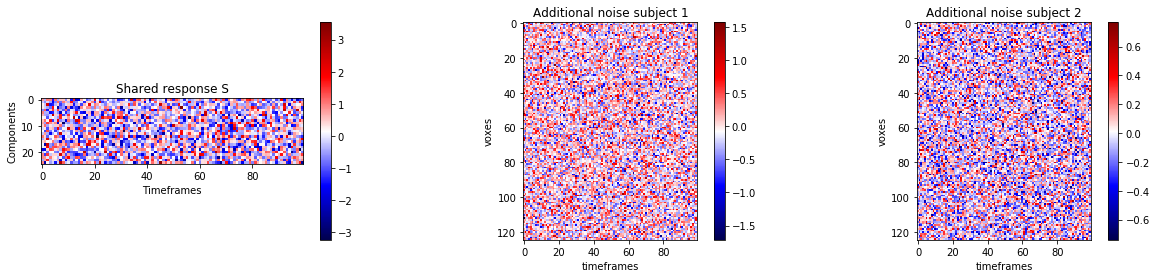

-------------------------------------------------------------------------------------
orthogonal


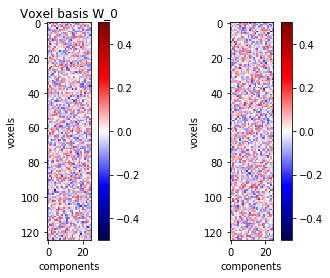

random


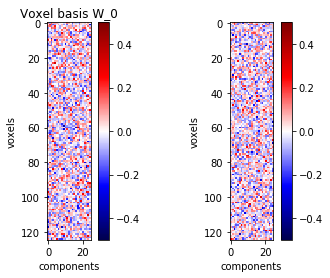

sparse


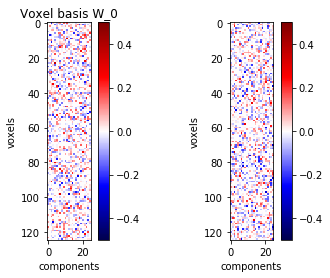

group_sparse


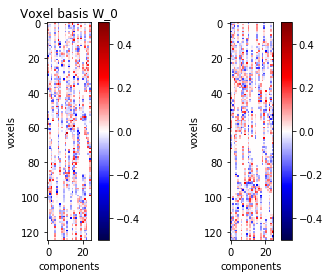

close_group_sparse


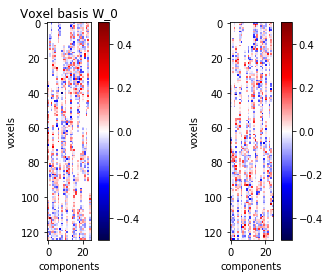

In [21]:
#n_samples is the number of subject
#n_component is the dimension of latent space


n_subjects = 20
n_components = 25
voxels = (5, 5, 5)
n_timeframes = 100

affine = np.eye(4)
shape = (voxels[0], voxels[1], voxels[2], n_timeframes)


#parameters
noise_scale = np.random.normal(loc=0, scale=0.7, size=n_subjects)**2
isotropicLatentVariance = np.eye(n_components)
isotropicLatentVariance = isotropicLatentVariance.T.dot(isotropicLatentVariance)

data = generate_fake_data(n_subjects=n_subjects,
                          n_components=n_components,
                          n_voxels=np.array(voxels).prod(),
                          n_timeframes=n_timeframes,
                          noise_scale=noise_scale,
                          latent_variance=isotropicLatentVariance,
                         )

train_W = data["train_W"]
train_S = data["train_S"]
test_S = data["test_S"]
test_noise = data["test_noise"]
train_noise = data["train_noise"]

methods = ["orthogonal", "random", "sparse", "group_sparse", "close_group_sparse"]
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.title("Shared response S")
plt.imshow(data["train_S"], cmap="seismic")
plt.xlabel("Timeframes")
plt.ylabel("Components")
plt.colorbar()
plt.subplot(132)
plt.title("Additional noise subject 1")
plt.imshow(data["train_noise"][0], cmap="seismic")
plt.xlabel("timeframes")
plt.ylabel("voxes")
plt.colorbar()
plt.subplot(133)
plt.title("Additional noise subject 2")
plt.imshow(data["train_noise"][1], cmap="seismic")
plt.xlabel("timeframes")
plt.ylabel("voxes")
plt.colorbar()
plt.savefig('fig1')
plt.show()

# print("Shared response (S of size k, t)")
# plt.imshow(test_S)
# plt.colorbar()
# plt.show()
print("-------------------------------------------------------------------------------------")
for method in methods:
    print(method)
    plt.subplot(121)
    i = 0
    plt.title("Voxel basis W_%i"%(i))
    plt.imshow(data["train_W"][method][i], cmap="seismic", vmax=0.5, vmin=-0.5)
    plt.ylabel("voxels")
    plt.xlabel("components")
    plt.colorbar()
    plt.subplot(122)
    i=1
    plt.imshow(data["train_W"][method][i], cmap="seismic", vmax=0.5, vmin=-0.5)
    plt.ylabel("voxels")
    plt.xlabel("components")
    plt.colorbar()
    plt.savefig('fig2_%s'%method)
    plt.show()

In [22]:
def initialize_algorithms(methods, n_components):
    algorithms = []
    for method in methods:
        algorithms.append([
            SRM(features=n_components, mask=masker), 
            DetSRM(features=n_components, mask=masker),
            DeterministicSRM(n_components=n_components, mask=masker),
            PCASRM(n_components=n_components, mask=masker)])
    return algorithms

algorithms_names = ["Probabilistic SRM",
                    "Deterministic SRM",
                    "Deterministic SRM 2",
                    "PCA",
                   ]

# Reconstruction procedure
- Fit on n - 1 subject and build shared space
- Map shared space to data of the nth subject
- Construct shared space of test data and predict data of leftout subject

In [23]:
algorithms = initialize_algorithms(methods, n_components)
test_subjects = np.random.randint(0, n_subjects, size=3)
plt.figure(figsize=(15, 5))
for i in range(len(methods)):
    method = methods[i]
    errors = []
    print(method)
    for j in range(len(algorithms[i])):
        algorithm = algorithms[i][j]
        masker = algorithm.masker
        train_X = [[
            masker.inverse_transform(
                (train_W[method][k].dot(train_S) + train_noise[k]).T
            )]
            for k in range(n_subjects)
        ]
        test_X = [[
            masker.inverse_transform(
                (train_W[method][k].dot(test_S) + test_noise[k]).T
            )]
            for k in range(n_subjects)
        ]
        
        error = []
        for s in test_subjects:
            print(s, test_subjects)
            index = np.delete(range(0, n_subjects), s)
            S = algorithm.fit_transform([train_X[ii] for ii in index])
            X_target = train_W[method][s].dot(train_S) + train_noise[s]
            r = Ridge(alpha=1e-8)
            r.fit(S.T, y=X_target.T)
            S_test = algorithm.transform([test_X[ii] for ii in index])
            X_pred = r.predict(S_test.T).T
            err = np.linalg.norm(X_pred - X_target)
            error.append(err - np.linalg.norm(train_W[method][s].dot(train_S) - X_target))
        errors.append(np.mean(error))
    plt.plot(algorithms_names, errors, '-', label=method)
plt.legend()
plt.savefig('fig5')
plt.show()

orthogonal
19 [19  0 15]
0 [19  0 15]
15 [19  0 15]
19 [19  0 15]
0 [19  0 15]
15 [19  0 15]


AttributeError: 'DeterministicSRM' object has no attribute 'masker'

<Figure size 1080x360 with 0 Axes>